In [1]:
import os 
import io
import matplotlib.pyplot as plt
from google.cloud import vision
from google.cloud.vision import enums
import cv2 as cv

from PIL import Image
import urllib.request

import gzip

from google.cloud.vision_v1.proto import image_annotator_pb2
from google.protobuf.json_format import MessageToDict

import re
from google.cloud import vision
from google.cloud import storage
from google.protobuf import json_format
from google.cloud import storage

## Set google cloud Credential

In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="my-project-12195-46fed19566f2.json"


## 1 -Extracting text from an image stored in local drive

### Step to extract the text from the image

1-Create a function that will take image as an input

2-Use ImageAnnotatorClient that performs Google Cloud Vision API detection tasks over client
images, such as face, landmark, logo, label, and text detection. 

3-The ImageAnnotator service returns detected entities from the images.In this case it will return response of text detection

4-Once the function is created we will call the function and pass the image path either local or stored in a url/gs

5- From the function we will get response and text as an output.

6- We will print them seprately to get the detail

7-Save the response .gz format through gzip whihc is used for compression and decompression of image

The above step would be repeated for image extratced through URL/LOCAL/GS


#### 1.1 Create a function that will take image path as an input and return the extraxted text from the image

In [130]:
def detect_text(path):
    """Detects text in the file."""
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()

    image = vision.types.Image(content=content)
    
    response = client.text_detection(image=image)
    texts = response.text_annotations
    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))
    return response,texts

#### We can directly print response and texts inside the function .But to know more about the output we are getting we are returning response and text from the function and will print it seprately

###  1.2 Read the image through imread

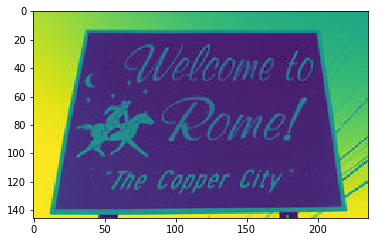

In [4]:
img = cv.imread("image.jpg",0)
plt.imshow(img)

#### 1.3 -Call the function the detect_text and unpack the return value response and texts
#### Print response

In [5]:
response,texts=detect_text('image.jpg')
print(response)

text_annotations {
  locale: "en"
  description: "Welcome to\n* Rome!\nThe Copper City\n"
  bounding_poly {
    vertices {
      x: 52
      y: 23
    }
    vertices {
      x: 199
      y: 23
    }
    vertices {
      x: 199
      y: 128
    }
    vertices {
      x: 52
      y: 128
    }
  }
}
text_annotations {
  description: "Welcome"
  bounding_poly {
    vertices {
      x: 65
      y: 23
    }
    vertices {
      x: 169
      y: 24
    }
    vertices {
      x: 169
      y: 52
    }
    vertices {
      x: 65
      y: 51
    }
  }
}
text_annotations {
  description: "to"
  bounding_poly {
    vertices {
      x: 173
      y: 23
    }
    vertices {
      x: 199
      y: 23
    }
    vertices {
      x: 199
      y: 56
    }
    vertices {
      x: 173
      y: 56
    }
  }
}
text_annotations {
  description: "*"
  bounding_poly {
    vertices {
      x: 77
      y: 62
    }
    vertices {
      x: 104
      y: 60
    }
    vertices {
      x: 107
      y: 100
    }
    vertice

**Result - 
Output of the Response consist of text_annotation and full_text_annotation 
To get text annotation we will call respone.text_annotaion and vice versa

**1-Text_annotaion** - It consist of three value
                    
                    LOCALE - That will tell the language used
                    Description - Description of text
                    Bounding Poly - That contain the vertices of the bounding polygon for the text in image
  
 Firstly it will give the vertices of polygon bounding the whole image and than give the vertices of  the individual word  
 present in the image

**2-Full_Text_Annotation** -It consist of :
                            
                            Pages that consist height and width of the complete text present in the image
                            Block that will create a bounded polygon around that page
                            Paragraphs that will give the vertices of the paragraph present inside the text
                            word will give vertices of each letter present in the text
                            Symbol will give vertices of any symbol present in the text


#### 1.4 Print text by fetching only the text and removing the coordinates

In [6]:
for text in texts:
    print('\n"{}"'.format(text.description))
    vertices = (['({},{})'.format(vertex.x, vertex.y)for vertex in text.bounding_poly.vertices])
    print('bounds: {}'.format(','.join(vertices)))


"Welcome to
* Rome!
The Copper City
"
bounds: (52,23),(199,23),(199,128),(52,128)

"Welcome"
bounds: (65,23),(169,24),(169,52),(65,51)

"to"
bounds: (173,23),(199,23),(199,56),(173,56)

"*"
bounds: (77,62),(104,60),(107,100),(80,102)

"Rome!"
bounds: (94,63),(191,56),(193,90),(96,97)

"The"
bounds: (52,113),(79,113),(79,125),(52,125)

"Copper"
bounds: (88,112),(138,112),(138,128),(88,128)

"City"
bounds: (146,111),(174,111),(174,127),(146,127)


### 1.5 Lets save the Response 

#### Serialized the response to string 

In [7]:
serialized = response.SerializeToString()

The response is converted into string

#### 1.6 Use gzip to save the converted File  

In [8]:
with gzip.open('response.local.gz', 'wb') as text_local:
    text_local.write(serialized)

1- In the above code gzip is used to save the code.GZip application is used for compression and decompression of files

2-The file will be saved in the given directory by the name given inside gzip.

3-To write the file mode is used as Write binary.Similarly there are other mode available in binary and text mode is also available.That can be used based on the operation required to perform

### 1.7-Open the saved response 

In [9]:
with gzip.open('response.local.gz', 'rb') as lf:
    Loaded=lf.read()
    parsed = image_annotator_pb2.AnnotateImageResponse()
    parsed.ParseFromString(Loaded)

print(MessageToDict(parsed))

{'textAnnotations': [{'locale': 'en', 'description': 'Welcome to\n* Rome!\nThe Copper City\n', 'boundingPoly': {'vertices': [{'x': 52, 'y': 23}, {'x': 199, 'y': 23}, {'x': 199, 'y': 128}, {'x': 52, 'y': 128}]}}, {'description': 'Welcome', 'boundingPoly': {'vertices': [{'x': 65, 'y': 23}, {'x': 169, 'y': 24}, {'x': 169, 'y': 52}, {'x': 65, 'y': 51}]}}, {'description': 'to', 'boundingPoly': {'vertices': [{'x': 173, 'y': 23}, {'x': 199, 'y': 23}, {'x': 199, 'y': 56}, {'x': 173, 'y': 56}]}}, {'description': '*', 'boundingPoly': {'vertices': [{'x': 77, 'y': 62}, {'x': 104, 'y': 60}, {'x': 107, 'y': 100}, {'x': 80, 'y': 102}]}}, {'description': 'Rome!', 'boundingPoly': {'vertices': [{'x': 94, 'y': 63}, {'x': 191, 'y': 56}, {'x': 193, 'y': 90}, {'x': 96, 'y': 97}]}}, {'description': 'The', 'boundingPoly': {'vertices': [{'x': 52, 'y': 113}, {'x': 79, 'y': 113}, {'x': 79, 'y': 125}, {'x': 52, 'y': 125}]}}, {'description': 'Copper', 'boundingPoly': {'vertices': [{'x': 88, 'y': 112}, {'x': 138, '

**Result**

1-To open the file we will used mode as rb

2-AnnotateImageResponse is used to  convert the response in the AnnotateImageResponse format

3-ParseFromString is used to convert the string into base type

## 2 -Extracting text from an image from a URL

#### 2.1Create a function that will take image path as an input and return the extraxted text from the image

In [129]:
def detect_text(uri):
    """Detects text in the file located in Google Cloud Storage or on the
    Web."""
    from google.cloud import vision
    client = vision.ImageAnnotatorClient()
    image = vision.types.Image()
    image.source.image_uri = uri

    response = client.text_detection(image=image)
    texts = response.text_annotations
    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))
    return response ,texts

#### 2.2 Read the image from the URL and plot it

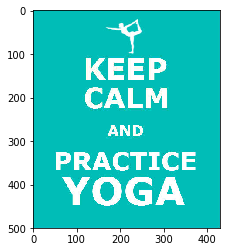

In [13]:
uri = 'https://holistichideaway.files.wordpress.com/2013/02/keep-calm-and-practice-yoga.jpg'
#uri = 'https://media1.popsugar-assets.com/files/thumbor/wMFVl8b_4TW-Cl8QfWlOhiJSPi8/fit-in/728xorig/filters:format_auto-!!-:strip_icc-!!-/2011/09/37/1/192/1922729/bf1d8d1076c2e82c_il_570xN.208614650/i/Keep-Calm-Yoga.jpg'

with urllib.request.urlopen(uri) as url:
    with open('temp.jpg', 'wb') as f:
        f.write(url.read())

img = Image.open('temp.jpg')
plt.imshow(img)

#### 2.3 Call the detect_text function and print the response

In [14]:
response,texts=detect_text(uri)
print(response)

text_annotations {
  locale: "en"
  description: "\320\232EEP\nCALM\nAND\nPRACTICE\nYOGA\n"
  bounding_poly {
    vertices {
      x: 52
      y: 112
    }
    vertices {
      x: 372
      y: 112
    }
    vertices {
      x: 372
      y: 449
    }
    vertices {
      x: 52
      y: 449
    }
  }
}
text_annotations {
  description: "\320\232EEP"
  bounding_poly {
    vertices {
      x: 122
      y: 112
    }
    vertices {
      x: 305
      y: 112
    }
    vertices {
      x: 305
      y: 159
    }
    vertices {
      x: 122
      y: 159
    }
  }
}
text_annotations {
  description: "CALM"
  bounding_poly {
    vertices {
      x: 120
      y: 178
    }
    vertices {
      x: 307
      y: 178
    }
    vertices {
      x: 307
      y: 225
    }
    vertices {
      x: 120
      y: 225
    }
  }
}
text_annotations {
  description: "AND"
  bounding_poly {
    vertices {
      x: 171
      y: 264
    }
    vertices {
      x: 252
      y: 264
    }
    vertices {
      x: 252
     

#### 2.4 Print text by fetching only the text and removing the coordinates

In [15]:
for text in texts:
    print('\n"{}"'.format(text.description))
    vertices = (['({},{})'.format(vertex.x, vertex.y)for vertex in text.bounding_poly.vertices])
    print('bounds: {}'.format(','.join(vertices)))


"КEEP
CALM
AND
PRACTICE
YOGA
"
bounds: (52,112),(372,112),(372,449),(52,449)

"КEEP"
bounds: (122,112),(305,112),(305,159),(122,159)

"CALM"
bounds: (120,178),(307,178),(307,225),(120,225)

"AND"
bounds: (171,264),(252,264),(252,288),(171,288)

"PRACTICE"
bounds: (52,325),(372,325),(372,368),(52,368)

"YOGA"
bounds: (68,382),(347,382),(347,449),(68,449)


#### 2.5-Save the Response

In [16]:
serialized = response.SerializeToString()
with gzip.open('response.url.gz', 'wb') as text_local:
    text_local.write(serialized)

#### 2.6 Open the Save Response file from the directory

In [17]:
with gzip.open('response.url.gz', 'rb') as lf:
    Loaded=lf.read()
    parsed = image_annotator_pb2.AnnotateImageResponse()
    parsed.ParseFromString(Loaded)

print(MessageToDict(parsed))

{'textAnnotations': [{'locale': 'en', 'description': 'КEEP\nCALM\nAND\nPRACTICE\nYOGA\n', 'boundingPoly': {'vertices': [{'x': 52, 'y': 112}, {'x': 372, 'y': 112}, {'x': 372, 'y': 449}, {'x': 52, 'y': 449}]}}, {'description': 'КEEP', 'boundingPoly': {'vertices': [{'x': 122, 'y': 112}, {'x': 305, 'y': 112}, {'x': 305, 'y': 159}, {'x': 122, 'y': 159}]}}, {'description': 'CALM', 'boundingPoly': {'vertices': [{'x': 120, 'y': 178}, {'x': 307, 'y': 178}, {'x': 307, 'y': 225}, {'x': 120, 'y': 225}]}}, {'description': 'AND', 'boundingPoly': {'vertices': [{'x': 171, 'y': 264}, {'x': 252, 'y': 264}, {'x': 252, 'y': 288}, {'x': 171, 'y': 288}]}}, {'description': 'PRACTICE', 'boundingPoly': {'vertices': [{'x': 52, 'y': 325}, {'x': 372, 'y': 325}, {'x': 372, 'y': 368}, {'x': 52, 'y': 368}]}}, {'description': 'YOGA', 'boundingPoly': {'vertices': [{'x': 68, 'y': 382}, {'x': 347, 'y': 382}, {'x': 347, 'y': 449}, {'x': 68, 'y': 449}]}}], 'fullTextAnnotation': {'pages': [{'property': {'detectedLanguages'

## 3 -Extracting text from an image stored in google storage

#### 3.1 Pass the location of the image stored in google cloud in vision.types.ImageSource

In [18]:
from google.cloud import vision

client_options = {'api_endpoint': 'eu-vision.googleapis.com'}

client = vision.ImageAnnotatorClient(client_options=client_options)
# [END vision_set_endpoint]
image_source = vision.types.ImageSource(
image_uri='gs://training-12195/traffic.jpg')
image = vision.types.Image(source=image_source)


In [19]:
type(image_source)

google.cloud.vision_v1.types.ImageSource

#### 3.2 Print the image

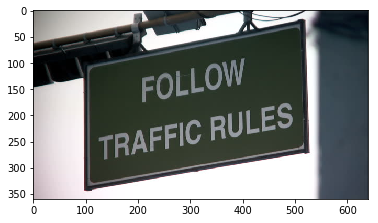

In [20]:
img = cv.imread("traffic.jpg",1)
plt.imshow(img)

#### 3.3 Print the response

In [51]:
response = client.text_detection(image=image)
print(response)
if response.error.message:
    raise Exception('{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

text_annotations {
  locale: "en"
  description: "FOLLOW\nTRAFFIC RULES\n"
  bounding_poly {
    vertices {
      x: 125
      y: 91
    }
    vertices {
      x: 499
      y: 91
    }
    vertices {
      x: 499
      y: 284
    }
    vertices {
      x: 125
      y: 284
    }
  }
}
text_annotations {
  description: "FOLLOW"
  bounding_poly {
    vertices {
      x: 201
      y: 129
    }
    vertices {
      x: 404
      y: 92
    }
    vertices {
      x: 413
      y: 141
    }
    vertices {
      x: 210
      y: 178
    }
  }
}
text_annotations {
  description: "TRAFFIC"
  bounding_poly {
    vertices {
      x: 125
      y: 239
    }
    vertices {
      x: 317
      y: 206
    }
    vertices {
      x: 325
      y: 251
    }
    vertices {
      x: 133
      y: 284
    }
  }
}
text_annotations {
  description: "RULES"
  bounding_poly {
    vertices {
      x: 334
      y: 204
    }
    vertices {
      x: 491
      y: 177
    }
    vertices {
      x: 498
      y: 221
    }
    

#### 3.4 -Print text by fetching only the text and removing the coordinates

In [22]:
for text in response.text_annotations:
    print('{}'.format(text.description))
    vertices = ['({},{})'.format(vertex.x, vertex.y)for vertex in text.bounding_poly.vertices]
    print('bounds: {}\n'.format(','.join(vertices)))    

FOLLOW
TRAFFIC RULES

bounds: (125,91),(499,91),(499,284),(125,284)

FOLLOW
bounds: (201,129),(404,92),(413,141),(210,178)

TRAFFIC
bounds: (125,239),(317,206),(325,251),(133,284)

RULES
bounds: (334,204),(491,177),(498,221),(342,248)



#### 3.5 Save the Response

In [23]:
serialized = response.SerializeToString()
with gzip.open('response.url.gz', 'wb') as text_local:
    text_local.write(serialized)

#### 3.6 Open the Save Response file from the directory

In [24]:
with gzip.open('response.url.gz', 'rb') as lf:
    Loaded=lf.read()
    parsed = image_annotator_pb2.AnnotateImageResponse()
    parsed.ParseFromString(Loaded)

print(MessageToDict(parsed))

{'textAnnotations': [{'locale': 'en', 'description': 'FOLLOW\nTRAFFIC RULES\n', 'boundingPoly': {'vertices': [{'x': 125, 'y': 91}, {'x': 499, 'y': 91}, {'x': 499, 'y': 284}, {'x': 125, 'y': 284}]}}, {'description': 'FOLLOW', 'boundingPoly': {'vertices': [{'x': 201, 'y': 129}, {'x': 404, 'y': 92}, {'x': 413, 'y': 141}, {'x': 210, 'y': 178}]}}, {'description': 'TRAFFIC', 'boundingPoly': {'vertices': [{'x': 125, 'y': 239}, {'x': 317, 'y': 206}, {'x': 325, 'y': 251}, {'x': 133, 'y': 284}]}}, {'description': 'RULES', 'boundingPoly': {'vertices': [{'x': 334, 'y': 204}, {'x': 491, 'y': 177}, {'x': 498, 'y': 221}, {'x': 342, 'y': 248}]}}], 'fullTextAnnotation': {'pages': [{'property': {'detectedLanguages': [{'languageCode': 'en', 'confidence': 1.0}]}, 'width': 640, 'height': 360, 'blocks': [{'property': {'detectedLanguages': [{'languageCode': 'en', 'confidence': 1.0}]}, 'boundingBox': {'vertices': [{'x': 201, 'y': 129}, {'x': 404, 'y': 92}, {'x': 413, 'y': 141}, {'x': 210, 'y': 178}]}, 'paragr

## 4 -Extracting text from an image stored in google storage and store the response in google storage

In [85]:
input_image_uri="gs://training-12195/traffic.jpg"
output_uri="gs://training-12195/image/"
 
#    """Perform async batch image annotation."""
client = vision_v1.ImageAnnotatorClient()

source = {"image_uri": input_image_uri}
image = {"source": source}
features = [
        {"type": enums.Feature.Type.TEXT_DETECTION},
    ]
print(features)


requests = [{"image": image, "features": features}]
gcs_destination = {"uri": output_uri}

# The max number of responses to output in each JSON file
batch_size = 2
output_config = {"gcs_destination": gcs_destination,
                     "batch_size": batch_size}

operation = client.async_batch_annotate_images(requests, output_config)

print("Waiting for operation to complete...")
response = operation.result(90)

# The output is written to GCS with the provided output_uri as prefix
gcs_output_uri = response.output_config.gcs_destination.uri


[{'type': <Type.TEXT_DETECTION: 5>}]
Waiting for operation to complete...


**Image is stored in - "gs://training-12195/image/""**

## 5-Detect Text in PDF file store in Google Storage

Step

1-Create a function that will take pdf path stored in google storage and destination path where our detected text will be stored

2-The function will be used Image annotator client and feature as document text detection

3-Use vision.types.GcsSource and pass input path where PDF file is stored in google storage

4-Use vision.types.GcsDestination and pass the ouput path where the detected text is stored

5- Use vision.types.AsyncAnnotateFileRequest which is an offline annotation request fucntion

6- Run asynchronous image detection and annotation through client.async_batch_annotate_files for a list of generic
files, such as PDF files, which may contain multiple pages and multiple
images per page

### 4.1 Create a function 

In [68]:
def async_detect_document(gcs_source_uri, gcs_destination_uri):
    """OCR with PDF/TIFF as source files on GCS"""
    # Supported mime_types are: 'application/pdf' and 'image/tiff'
    mime_type = 'application/pdf'

    # How many pages should be grouped into each json output file.
    batch_size = 2

    client = vision.ImageAnnotatorClient()

    feature = vision.types.Feature(
        type=vision.enums.Feature.Type.DOCUMENT_TEXT_DETECTION)

    gcs_source = vision.types.GcsSource(uri=gcs_source_uri)
    input_config = vision.types.InputConfig(
        gcs_source=gcs_source, mime_type=mime_type)

    gcs_destination = vision.types.GcsDestination(uri=gcs_destination_uri)
    output_config = vision.types.OutputConfig(
        gcs_destination=gcs_destination, batch_size=batch_size)

    async_request = vision.types.AsyncAnnotateFileRequest(
        features=[feature], input_config=input_config,
        output_config=output_config)

    operation = client.async_batch_annotate_files(
        requests=[async_request])

    print('Waiting for the operation to finish.')
    operation.result(timeout=420)


### 4.2 Call the function
Save the source and destination path 

In [69]:
gcs_source_uri="gs://training-12195/testdocument.pdf"
gcs_destination_uri= "gs://training-12195/pdf1/custom.pdf"
async_detect_document(gcs_source_uri, gcs_destination_uri)

Waiting for the operation to finish.


**The output file is stored in gs://training-12195/pdf1/**

### 4.3 Check the output file

In [70]:
# Once the request has completed and the output has been
# written to GCS, we can list all the output files.
storage_client = storage.Client()

match = re.match(r'gs://([^/]+)/(.+)', gcs_destination_uri)
bucket_name = match.group(1)
prefix = match.group(2)

bucket = storage_client.get_bucket(bucket_name)
 
    # List objects with the given prefix.
blob_list = list(bucket.list_blobs(prefix=prefix))
print('Output files:')
for blob in blob_list:
    print(blob.name)


Output files:
pdf1/custom.pdfoutput-1-to-2.json
pdf1/custom.pdfoutput-3-to-4.json
pdf1/custom.pdfoutput-5-to-5.json


### 4.4 Print the text extracted from the PDF 

In [71]:
# Process the first output file from GCS.
# Since we specified batch_size=2, the first response contains
# the first two pages of the input file.
output = blob_list[0]
json_string = output.download_as_string()
response = json_format.Parse(
    json_string, vision.types.AnnotateFileResponse())

# The actual response for the first page of the input file.
first_page_response = response.responses[0]
annotation = first_page_response.full_text_annotation

# Here we print the full text from the first page.
# The response contains more information:
# annotation/pages/blocks/paragraphs/words/symbols
# including confidence scores and bounding boxes
print(u'Full text:\n{}'.format(
        annotation.text))

Full text:
pdf995
Create PDF files quickly and easily!
The pdf995 suite of products - Pdf995, PdfEdit995, and Signature995 - is a complete solution for your document publishing needs. It
provides ease of use, flexibility in format, and industry-standard security- and all at no cost to you.
Pdf995 makes it easy and affordable to create professional-quality documents in the popular PDF file format. Its easy-to-use interface
helps you to create PDF files by simply selecting the "print" command from any application, creating documents which can be viewed
on any computer with a PDF viewer. Pdf995 supports network file saving, fast user switching on XP, Citrix/Terminal Server, custom
page sizes and large format printing. Pdf995 is a printer driver that works with any Postscript to PDF converter. The pdf995 printer
driver and a free Converter are available for easy download.
PdfEdit995 offers a wealth of additional functionality, such as: combining documents into a single PDF; automatic link 

## 5-Detect Text in PDF file stored in local

#### The below function will take pdf stored in a local file and print the response 

In [86]:
def sample_batch_annotate_files(file_path="testdocument.pdf"):
    """Perform batch file annotation."""
    client = vision_v1.ImageAnnotatorClient()

    # Supported mime_type: application/pdf, image/tiff, image/gif
    mime_type = "application/pdf"
    with io.open(file_path, "rb") as f:
        content = f.read()
    input_config = {"mime_type": mime_type, "content": content}
    features = [{"type": enums.Feature.Type.DOCUMENT_TEXT_DETECTION}]

    # The service can process up to 5 pages per document file. Here we specify
    # the first, second, and last page of the document to be processed.
    pages = [1, 2, -1]
    requests = [{"input_config": input_config, "features": features, "pages": pages}]

    response = client.batch_annotate_files(requests)
    for image_response in response.responses[0].responses:
        print(u"Full text: {}".format(image_response.full_text_annotation.text))
        for page in image_response.full_text_annotation.pages:
            for block in page.blocks:
                print(u"\nBlock confidence: {}".format(block.confidence))
                for par in block.paragraphs:
                    print(u"\tParagraph confidence: {}".format(par.confidence))
                    for word in par.words:
                        print(u"\t\tWord confidence: {}".format(word.confidence))
                        for symbol in word.symbols:
                            print(
                                u"\t\t\tSymbol: {}, (confidence: {})".format(
                                    symbol.text, symbol.confidence
                                )
                            )

#### Call the function

In [87]:
sample_batch_annotate_files()

Full text: pdf995
Create PDF files quickly and easily!
The pdf995 suite of products - Pdf995, PdfEdit995, and Signature995 - is a complete solution for your document publishing needs. It
provides ease of use, flexibility in format, and industry-standard security- and all at no cost to you.
Pdf995 makes it easy and affordable to create professional-quality documents in the popular PDF file format. Its easy-to-use interface
helps you to create PDF files by simply selecting the "print" command from any application, creating documents which can be viewed
on any computer with a PDF viewer. Pdf995 supports network file saving, fast user switching on XP, Citrix/Terminal Server, custom
page sizes and large format printing. Pdf995 is a printer driver that works with any Postscript to PDF converter. The pdf995 printer
driver and a free Converter are available for easy download.
PdfEdit995 offers a wealth of additional functionality, such as: combining documents into a single PDF; automatic link 

			Symbol: h, (confidence: 1.0)
		Word confidence: 0.9900000095367432
			Symbol: t, (confidence: 1.0)
			Symbol: o, (confidence: 0.9900000095367432)
		Word confidence: 0.9900000095367432
			Symbol: e, (confidence: 0.9900000095367432)
			Symbol: m, (confidence: 0.9900000095367432)
			Symbol: a, (confidence: 0.9900000095367432)
			Symbol: i, (confidence: 1.0)
			Symbol: l, (confidence: 1.0)
		Word confidence: 0.9900000095367432
			Symbol: ;, (confidence: 0.9900000095367432)
		Word confidence: 0.9900000095367432
			Symbol: s, (confidence: 0.9900000095367432)
			Symbol: t, (confidence: 0.9900000095367432)
			Symbol: a, (confidence: 1.0)
			Symbol: t, (confidence: 0.9900000095367432)
			Symbol: i, (confidence: 1.0)
			Symbol: o, (confidence: 1.0)
			Symbol: n, (confidence: 1.0)
			Symbol: e, (confidence: 0.9900000095367432)
			Symbol: r, (confidence: 1.0)
			Symbol: y, (confidence: 1.0)
		Word confidence: 0.9900000095367432
			Symbol: a, (confidence: 0.9900000095367432)
			Symbol: n, (confi

		Word confidence: 0.9900000095367432
			Symbol: f, (confidence: 0.9900000095367432)
			Symbol: o, (confidence: 0.9900000095367432)
			Symbol: r, (confidence: 1.0)
			Symbol: m, (confidence: 0.9900000095367432)
			Symbol: a, (confidence: 0.9900000095367432)
			Symbol: t, (confidence: 1.0)
		Word confidence: 0.9900000095367432
			Symbol: a, (confidence: 0.9900000095367432)
			Symbol: r, (confidence: 0.9900000095367432)
			Symbol: c, (confidence: 0.9900000095367432)
			Symbol: h, (confidence: 1.0)
			Symbol: i, (confidence: 1.0)
			Symbol: t, (confidence: 0.9900000095367432)
			Symbol: e, (confidence: 1.0)
			Symbol: c, (confidence: 0.9900000095367432)
			Symbol: t, (confidence: 1.0)
			Symbol: u, (confidence: 1.0)
			Symbol: r, (confidence: 1.0)
			Symbol: a, (confidence: 1.0)
			Symbol: l, (confidence: 0.9900000095367432)
		Word confidence: 0.9900000095367432
			Symbol: p, (confidence: 0.9900000095367432)
			Symbol: r, (confidence: 0.9900000095367432)
			Symbol: i, (confidence: 0.99000

			Symbol: o, (confidence: 1.0)
			Symbol: d, (confidence: 0.9900000095367432)
			Symbol: e, (confidence: 1.0)
			Symbol: l, (confidence: 0.9900000095367432)
			Symbol: i, (confidence: 0.9900000095367432)
			Symbol: n, (confidence: 1.0)
			Symbol: g, (confidence: 1.0)
		Word confidence: 0.9900000095367432
			Symbol: L, (confidence: 0.9900000095367432)
			Symbol: a, (confidence: 1.0)
			Symbol: n, (confidence: 0.9900000095367432)
			Symbol: g, (confidence: 0.9900000095367432)
			Symbol: u, (confidence: 1.0)
			Symbol: a, (confidence: 1.0)
			Symbol: g, (confidence: 1.0)
			Symbol: e, (confidence: 1.0)
		Word confidence: 0.9900000095367432
			Symbol: (, (confidence: 0.9900000095367432)
		Word confidence: 0.9900000095367432
			Symbol: V, (confidence: 0.9900000095367432)
			Symbol: R, (confidence: 0.9900000095367432)
			Symbol: M, (confidence: 0.9900000095367432)
			Symbol: L, (confidence: 0.9900000095367432)
		Word confidence: 0.9900000095367432
			Symbol: ), (confidence: 0.99000000953674

			Symbol: s, (confidence: 1.0)
		Word confidence: 0.9900000095367432
			Symbol: o, (confidence: 0.9900000095367432)
			Symbol: f, (confidence: 1.0)
		Word confidence: 0.9900000095367432
			Symbol: V, (confidence: 0.9900000095367432)
			Symbol: R, (confidence: 0.9900000095367432)
			Symbol: M, (confidence: 0.9900000095367432)
			Symbol: L, (confidence: 0.9900000095367432)
		Word confidence: 0.9900000095367432
			Symbol: w, (confidence: 0.9900000095367432)
			Symbol: i, (confidence: 1.0)
			Symbol: l, (confidence: 0.9900000095367432)
			Symbol: l, (confidence: 1.0)
		Word confidence: 0.9900000095367432
			Symbol: a, (confidence: 0.9900000095367432)
			Symbol: l, (confidence: 1.0)
			Symbol: l, (confidence: 0.9900000095367432)
			Symbol: o, (confidence: 1.0)
			Symbol: w, (confidence: 1.0)
		Word confidence: 0.9900000095367432
			Symbol: f, (confidence: 0.9900000095367432)
			Symbol: o, (confidence: 1.0)
			Symbol: r, (confidence: 1.0)
		Word confidence: 0.9900000095367432
			Symbol: r, 

			Symbol: e, (confidence: 1.0)
			Symbol: s, (confidence: 1.0)
			Symbol: s, (confidence: 1.0)
			Symbol: i, (confidence: 0.9900000095367432)
			Symbol: n, (confidence: 1.0)
			Symbol: g, (confidence: 1.0)
		Word confidence: 0.9900000095367432
			Symbol: ", (confidence: 0.9900000095367432)
		Word confidence: 0.9900000095367432
			Symbol: s, (confidence: 0.9900000095367432)
			Symbol: c, (confidence: 0.9900000095367432)
			Symbol: h, (confidence: 0.9900000095367432)
			Symbol: e, (confidence: 0.9900000095367432)
			Symbol: m, (confidence: 0.9900000095367432)
			Symbol: e, (confidence: 1.0)
		Word confidence: 0.9900000095367432
			Symbol: ,, (confidence: 0.9900000095367432)
		Word confidence: 0.9900000095367432
			Symbol: a, (confidence: 0.9900000095367432)
		Word confidence: 0.9900000095367432
			Symbol: u, (confidence: 0.9900000095367432)
			Symbol: n, (confidence: 1.0)
			Symbol: i, (confidence: 0.9900000095367432)
			Symbol: q, (confidence: 0.9900000095367432)
			Symbol: u, (confide

			Symbol: s, (confidence: 1.0)
			Symbol: t, (confidence: 1.0)
		Word confidence: 0.9900000095367432
			Symbol: f, (confidence: 0.9900000095367432)
			Symbol: o, (confidence: 0.9900000095367432)
			Symbol: r, (confidence: 1.0)
		Word confidence: 0.9900000095367432
			Symbol: d, (confidence: 0.9900000095367432)
			Symbol: o, (confidence: 0.9900000095367432)
			Symbol: w, (confidence: 0.9900000095367432)
			Symbol: n, (confidence: 1.0)
			Symbol: l, (confidence: 1.0)
			Symbol: o, (confidence: 1.0)
			Symbol: a, (confidence: 1.0)
			Symbol: d, (confidence: 1.0)
		Word confidence: 0.9900000095367432
			Symbol: r, (confidence: 0.9900000095367432)
			Symbol: a, (confidence: 1.0)
			Symbol: t, (confidence: 0.9900000095367432)
			Symbol: e, (confidence: 0.9900000095367432)
		Word confidence: 0.9800000190734863
			Symbol: a, (confidence: 0.9599999785423279)
			Symbol: n, (confidence: 1.0)
			Symbol: d, (confidence: 0.9900000095367432)
		Word confidence: 0.9900000095367432
			Symbol: /, (confi

## 6 -Batch processing of a folder with images stored on local folder

**Step

1-Create a folder of image

2-Loop in over each image present in the folder 

3-Create an array of Annotate image request for each image

4-Create the batch annotate image that will give response for each image

5-Loop in over the response and print each response

In [99]:
from google.cloud import vision
from google.cloud.vision import enums
from google.cloud.vision import types

features = [
    types.Feature(type=enums.Feature.Type.TEXT_DETECTION),
]

requests = []
directory = 'folder'
for file_name in os.listdir(directory):
    with open(file_name, 'rb') as image_file:
        image = types.Image(
            content = image_file.read())
    request = types.AnnotateImageRequest(
        image=image, features=features)
    requests.append(request)

response = client.batch_annotate_images(requests)

for annotation_response in response.responses:
    print(annotation_response)

text_annotations {
  locale: "en"
  description: "Welcome to\n* Rome!\nThe Copper City\n"
  bounding_poly {
    vertices {
      x: 52
      y: 23
    }
    vertices {
      x: 199
      y: 23
    }
    vertices {
      x: 199
      y: 128
    }
    vertices {
      x: 52
      y: 128
    }
  }
}
text_annotations {
  description: "Welcome"
  bounding_poly {
    vertices {
      x: 65
      y: 23
    }
    vertices {
      x: 169
      y: 24
    }
    vertices {
      x: 169
      y: 52
    }
    vertices {
      x: 65
      y: 51
    }
  }
}
text_annotations {
  description: "to"
  bounding_poly {
    vertices {
      x: 173
      y: 23
    }
    vertices {
      x: 199
      y: 23
    }
    vertices {
      x: 199
      y: 56
    }
    vertices {
      x: 173
      y: 56
    }
  }
}
text_annotations {
  description: "*"
  bounding_poly {
    vertices {
      x: 77
      y: 62
    }
    vertices {
      x: 104
      y: 60
    }
    vertices {
      x: 107
      y: 100
    }
    vertice

In [140]:
directory = 'folder'
for file_name in os.listdir(directory):
    print(file_name)

image.jpg
keep-left.jpg
Yoga.jpg


## 7 Batch processing of a folder with images stored on GS

#### Create a function that will take bunch of images as an input and created an array of response and stored it in google storage

In [103]:
from google.cloud import vision_v1
from google.cloud.vision_v1 import enums


def sample_async_batch_annotate_images(
    input_image_uri=("gs://cloud-samples-data/vision/label/wakeupcat.jpg"),
    output_uri="gs://training-12195/test5",
):
    """Perform async batch image annotation."""
    client = vision_v1.ImageAnnotatorClient()

    source = {"image_uri": input_image_uri}
    image = {"source": source}
    features = [
        {"type": enums.Feature.Type.TEXT_DETECTION},
    ]
    print(features)

    # Each requests element corresponds to a single image.  To annotate more
    # images, create a request element for each image and add it to
    # the array of requests
    requests = [{"image": image, "features": features}]
    gcs_destination = {"uri": output_uri}

    # The max number of responses to output in each JSON file
    batch_size = 2
    output_config = {"gcs_destination": gcs_destination,
                     "batch_size": batch_size}

    operation = client.async_batch_annotate_images(requests, output_config)

    print("Waiting for operation to complete...")
    response = operation.result(90)

    # The output is written to GCS with the provided output_uri as prefix
    gcs_output_uri = response.output_config.gcs_destination.uri
    print("Output written to GCS with prefix: {}".format(gcs_output_uri))


#### Call the function

In [104]:
sample_async_batch_annotate_images()

[{'type': <Type.TEXT_DETECTION: 5>}]
Waiting for operation to complete...
Output written to GCS with prefix: gs://training-12195/test5


##### Output written to GCS with prefix: gs://training-12195/test5

## 8) Detect document text in a remote image (hand-written image)

In [111]:
# Detect document text in a remote image
def detect_document_uri(uri):
    """Detects document features in the file located in Google Cloud
    Storage."""
    from google.cloud import vision
    client = vision.ImageAnnotatorClient()
    image = vision.types.Image()
    image.source.image_uri = uri

    response = client.document_text_detection(image=image)
    print('response:\n ', response)
    
    for page in response.full_text_annotation.pages:
        for block in page.blocks:
            print('\nBlock confidence: {}\n'.format(block.confidence))

            for paragraph in block.paragraphs:
                print('Paragraph confidence: {}'.format(
                    paragraph.confidence))

                for word in paragraph.words:
                    word_text = ''.join([
                        symbol.text for symbol in word.symbols
                    ])
                    print('Word text: {} (confidence: {})'.format(
                        word_text, word.confidence))

                    for symbol in word.symbols:
                        print('\tSymbol: {} (confidence: {})'.format(
                            symbol.text, symbol.confidence))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

##### Print the image

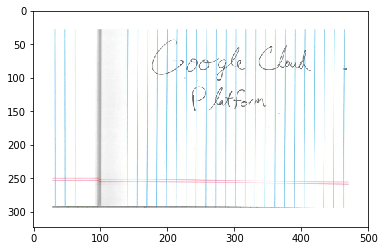

In [137]:
# Remote image used 
img=plt.imread('text12.png')
plt.imshow(img)

#### Firstly we will call our detect_text function to detect the hand image

In [138]:
detect_text('text12.png')

(text_annotations {
   locale: "en"
   description: "Google Clancd\nPletform\n"
   bounding_poly {
     vertices {
       x: 169
       y: 43
     }
     vertices {
       x: 417
       y: 43
     }
     vertices {
       x: 417
       y: 151
     }
     vertices {
       x: 169
       y: 151
     }
   }
 }
 text_annotations {
   description: "Google"
   bounding_poly {
     vertices {
       x: 169
       y: 50
     }
     vertices {
       x: 317
       y: 46
     }
     vertices {
       x: 318
       y: 104
     }
     vertices {
       x: 170
       y: 108
     }
   }
 }
 text_annotations {
   description: "Clancd"
   bounding_poly {
     vertices {
       x: 341
       y: 45
     }
     vertices {
       x: 416
       y: 43
     }
     vertices {
       x: 417
       y: 102
     }
     vertices {
       x: 342
       y: 104
     }
   }
 }
 text_annotations {
   description: "Pletform"
   bounding_poly {
     vertices {
       x: 229
       y: 110
     }
     vertices {
       x: 

**From the above response we can clearly see that the text is not predicted correctly.Cloud is predicted as clancd** 

### Lets Call the detect_document_uri function and check if it will predict correctly or not

In [139]:
uri ="gs://training-12195/text12.png"
detect_document_uri(uri)


response:
  text_annotations {
  locale: "en"
  description: "Google Cloud\nPlatform\n"
  bounding_poly {
    vertices {
      x: 226
      y: 33
    }
    vertices {
      x: 422
      y: 33
    }
    vertices {
      x: 422
      y: 151
    }
    vertices {
      x: 226
      y: 151
    }
  }
}
text_annotations {
  description: "Google"
  bounding_poly {
    vertices {
      x: 226
      y: 35
    }
    vertices {
      x: 316
      y: 34
    }
    vertices {
      x: 317
      y: 106
    }
    vertices {
      x: 227
      y: 107
    }
  }
}
text_annotations {
  description: "Cloud"
  bounding_poly {
    vertices {
      x: 348
      y: 34
    }
    vertices {
      x: 421
      y: 33
    }
    vertices {
      x: 422
      y: 104
    }
    vertices {
      x: 349
      y: 105
    }
  }
}
text_annotations {
  description: "Platform"
  bounding_poly {
    vertices {
      x: 249
      y: 111
    }
    vertices {
      x: 341
      y: 111
    }
    vertices {
      x: 341
      y: 151

##### From the above response we can see that the text is predicted correctly.